## Preprocess audio files and corresponding .svl files to create X (spectrograms) and Y variables to train ML algorithms.


#### Copyright Emmanuel Dufourq 2021

#### African Institute for Mathematical Sciences

#### Stellenbosch University

#### EdgeAcoustics NPO

#### edufourq@gmail.com

<hr>

### Folder structure required:

Species Folder (root folder). Subfolders:

----Annotations
    
----Audio
    
----Saved_Data
    
----DataFiles
    
Annotations folder should contain all the .svl files

Audio folder should contain all the .WAV files

DataFiles folder should contain two files: TrainingFiles.txt and TestingFiles.txt

Saved_Data folder will be empty. This script will produce two outputs: X.pkl and Y.pkl which will be saved in this folder

In [1]:
import glob, os
import numpy as np
import random
import librosa.display
import librosa
from xml.dom import minidom
from scipy import signal
from random import randint
import pickle
from matplotlib import pyplot as plt
import pandas as pd
import math
from AnnotationReader import *

In [2]:
class Preprocessing:
    
    def __init__(self, species_folder, lowpass_cutoff, 
                 downsample_rate, nyquist_rate, segment_duration, 
                 positive_class, background_class,
                 augmentation_amount_positive_class,
                 augmentation_amount_background_class,
                 n_fft, hop_length, n_mels, f_min, f_max, file_type, audio_extension):
        self.species_folder = species_folder
        self.lowpass_cutoff = lowpass_cutoff
        self.downsample_rate = downsample_rate
        self.nyquist_rate = nyquist_rate
        self.segment_duration = segment_duration
        self.augmentation_amount_positive_class = augmentation_amount_positive_class
        self.augmentation_amount_background_class = augmentation_amount_background_class
        self.positive_class = positive_class
        self.background_class = background_class
        self.audio_path = self.species_folder + '/Audio/'
        self.annotations_path = self.species_folder + '/Annotations/'
        self.saved_data_path = self.species_folder + '/Saved_Data/'
        self.training_files = self.species_folder + '/DataFiles/TrainingFiles.txt'
        self.n_ftt = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.f_min = f_min
        self.f_max = f_max
        self.file_type = file_type
        self.audio_extension = audio_extension
        
    def update_audio_path(self, audio_path):
        self.audio_path = self.species_folder + '/Audio/' + audio_path
        
    def read_audio_file(self, file_name):
        '''
        file_name: string, name of file including extension, e.g. "audio1.wav"
        
        '''
        # Get the path to the file
        audio_folder = os.path.join(self.species_folder, 'Audio',file_name)
        
        # Read the amplitudes and sample rate
        audio_amps, audio_sample_rate = librosa.load(audio_folder, sr=None)
        
        return audio_amps, audio_sample_rate
    
    def butter_lowpass(self, cutoff, nyq_freq, order=4):
        normal_cutoff = float(cutoff) / nyq_freq
        b, a = signal.butter(order, normal_cutoff, btype='lowpass')
        return b, a

    def butter_lowpass_filter(self, data, cutoff_freq, nyq_freq, order=4):
        # Source: https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform
        b, a = self.butter_lowpass(cutoff_freq, nyq_freq, order=order)
        y = signal.filtfilt(b, a, data)
        return y

    def downsample_file(self, amplitudes, original_sr, new_sample_rate):
        '''
        Downsample an audio file to a given new sample rate.
        amplitudes:
        original_sr:
        new_sample_rate:
        
        '''
        return librosa.resample(amplitudes, 
                                original_sr, 
                                new_sample_rate, 
                                res_type='kaiser_fast'), new_sample_rate

    def convert_single_to_image(self, audio):
        '''
        Convert amplitude values into a mel-spectrogram.
        '''
        S = librosa.feature.melspectrogram(audio, n_fft=self.n_ftt,hop_length=self.hop_length, 
                                           n_mels=self.n_mels, fmin=self.f_min, fmax=self.f_max)
        
        image = librosa.core.power_to_db(S)
        image_np = np.asmatrix(image)
        image_np_scaled_temp = (image_np - np.min(image_np))
        image_np_scaled = image_np_scaled_temp / np.max(image_np_scaled_temp)
        mean = image.flatten().mean()
        std = image.flatten().std()
        eps=1e-8
        spec_norm = (image - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = (spec_norm - spec_min) / (spec_max - spec_min)
        spectrogram = spec_scaled
        
        return spectrogram

    def convert_all_to_image(self, segments):
        '''
        Convert a number of segments into their corresponding spectrograms.
        '''
        spectrograms = []
        for segment in segments:
            spectrograms.append(self.convert_single_to_image(segment))

        return np.array(spectrograms)
    
    def add_extra_dim(self, spectrograms):
        '''
        Add an extra dimension to the data so that it matches
        the input requirement of Tensorflow.
        '''
        spectrograms = np.reshape(spectrograms, 
                                  (spectrograms.shape[0],
                                   spectrograms.shape[1],
                                   spectrograms.shape[2],1))
        return spectrograms
    
    def time_shift(self, audio, shift):
        '''
        Shift ampltitude values (to the right) by a random value.
        Values are wrapped back to the left.
        '''

        augmented = np.zeros(len(audio))
        augmented [0:shift] = audio[-shift:]
        augmented [shift:] = audio[:-shift]
        return augmented
    
    def augment_single_segment(self, segment, label, verbose):
        '''
        Augment a segment of amplitude values a number of times (pre-defined).
        Augmenting is done by applying a time shift.
        '''
    
        augmented_segments = []
        augmented_labels = []
        
        if label in self.positive_class:
            augmentation_amount = self.augmentation_amount_positive_class
        else:
            augmentation_amount = self.augmentation_amount_background_class

        for i in range (0, augmentation_amount):

            if verbose:
                print ('augmentation iteration', i)
                print ('----------------------------')

            # Randomly select amount to shift by
            random_time_point_segment = randint(1, len(segment)-1)

            # Time shift
            segment = self.time_shift(segment, random_time_point_segment)

            # Append the augmented segments
            augmented_segments.append(segment)
            
            # Append the label (a multiclass problem can be converted into
            # one-hot encoded vectors at a later stage)
            augmented_labels.append(label)

        return augmented_segments, augmented_labels
    
    def getXY(self, audio_amplitudes, start_sec, annotation_duration_seconds, label, verbose):
        '''
        Extract a number of segments based on the user-annotations.
        If possible, a number of segments are extracted provided
        that the duration of the annotation is long enough. The segments
        are extracted by shifting by 1 second in time to the right.
        Each segment is then augmented a number of times based on a pre-defined
        user value.
        '''

        if verbose == True:
            print ('start_sec', start_sec)
            print ('annotation_duration_seconds', annotation_duration_seconds)
            print ('self.segment_duration ', self.segment_duration )
            
        X_augmented_segments = []
        Y_augmented_labels = []
            
        # Calculate how many segments can be extracted based on the duration of
        # the annotated duration. If the annotated duration is too short then
        # simply extract one segment. If the annotated duration is long enough
        # then multiple segments can be extracted.
        if annotation_duration_seconds-self.segment_duration < 0:
            segments_to_extract = 1
        else:
            segments_to_extract = annotation_duration_seconds-self.segment_duration+1
            
        if verbose:
            print ("segments_to_extract", segments_to_extract)
            
        if label in self.background_class:
            if segments_to_extract > 5:
                segments_to_extract = 5
            
        for i in range (0, segments_to_extract):
            if verbose:
                print ('Semgnet {} of {}'.format(i, segments_to_extract-1))
                print ('*******************')
                
            # Set the correct location to start with.
            # The correct start is with respect to the location in time
            # in the audio file start+i*sample_rate
            start_data_observation = start_sec*self.downsample_rate+i*(self.downsample_rate)
            # The end location is based off the start
            end_data_observation = start_data_observation + (self.downsample_rate*self.segment_duration)
            
            # This case occurs when something is annotated towards the end of a file
            # and can result in a segment which is too short.
            if end_data_observation > len(audio_amplitudes):
                continue

            # Extract the segment of audio
            X_audio = audio_amplitudes[start_data_observation:end_data_observation]

            if verbose == True:
                print ('start frame', start_data_observation)
                print ('end frame', end_data_observation)
            
            # Augment the segment a number of times
            X_augmented, Y_augmented = self.augment_single_segment(X_audio, label, verbose)
            
            # Extend the augmented segments and labels
            X_augmented_segments.extend(X_augmented)
            Y_augmented_labels.extend(Y_augmented)

        return X_augmented_segments, Y_augmented_labels
    
    def save_data_to_pickle(self, X, Y):
        '''
        Save all of the spectrograms to a pickle file.
        
        '''
        outfile = open(os.path.join(self.saved_data_path, 'X.pkl'),'wb')
        pickle.dump(X, outfile, protocol=4)
        outfile.close()
        
        outfile = open(os.path.join(self.saved_data_path, 'Y.pkl'),'wb')
        pickle.dump(Y, outfile, protocol=4)
        outfile.close()
        
    def load_data_from_pickle(self):
        '''
        Load all of the spectrograms from a pickle file
        
        '''
        infile = open(os.path.join(self.saved_data_path, 'X.pkl'),'rb')
        X = pickle.load(infile)
        infile.close()
        
        infile = open(os.path.join(self.saved_data_path, 'Y.pkl'),'rb')
        Y = pickle.load(infile)
        infile.close()

        return X, Y

    def create_dataset(self, verbose):
        '''
        Create X and Y values which are inputs to a ML algorithm.
        Annotated files (.svl) are read and the corresponding audio file (.wav)
        is read. A low pass filter is applied, followed by downsampling. A 
        number of segments are extracted and augmented to create the final dataset.
        Annotated files (.svl) are created using SonicVisualiser and it is assumed
        that the "boxes area" layer was used to annotate the audio files.
        '''
        
        # Keep track of how many calls were found in the annotation files
        total_calls = 0

        # Initialise lists to store the X and Y values
        X_calls = []
        Y_calls = []
        
        if verbose == True:
            print ('Annotations path:',self.annotations_path+"*.svl")
            print ('Audio path',self.audio_path+"*.wav")
        
        # Read all names of the training files
        training_files = pd.read_csv(self.training_files, header=None)
        
        # Iterate over each annotation file
        for training_file in training_files.values:
            
            file = training_file[0]
            
            if file_type == 'svl':
                # Get the file name without paths and extensions
                file_name_no_extension = file

            if file_type == 'raven_caovitgibbons':
                file_name_no_extension = file[file.rfind('-')+1:file.find('.')]
                
            print ('Processing:',file_name_no_extension)
            
            reader = AnnotationReader(file, self.species_folder, self.file_type, self.audio_extension)

            self.update_audio_path(reader.get_audio_location())

            # Check if the .wav file exists before processing
            if self.audio_path+file_name_no_extension+self.audio_extension  in glob.glob(self.audio_path+"*"+self.audio_extension):

                name = file[file.find('_')+1:file.find('.')]+self.audio_extension 

                # Read audio file
                audio_amps, original_sample_rate = self.read_audio_file(self.audio_path+file_name_no_extension+self.audio_extension )

                # Low pass filter
                filtered = self.butter_lowpass_filter(audio_amps, self.lowpass_cutoff, self.nyquist_rate)

                # Downsample
                amplitudes, sample_rate = self.downsample_file(filtered, original_sample_rate, self.downsample_rate)

                df, audio_file_name = reader.get_annotation_information()

                for index, row in df.iterrows():

                    start_seconds = math.floor(row['Start'])
                    end_seconds = math.ceil(row['End'])
                    label = row['Label']
                    annotation_duration_seconds = end_seconds - start_seconds

                    # Extract augmented audio segments and corresponding binary labels
                    X_data, y_data = self.getXY(amplitudes, start_seconds, 
                                                annotation_duration_seconds, label, verbose)

                    # Convert audio amplitudes to spectrograms
                    X_data = self.convert_all_to_image(X_data)

                    # Append the segments and labels
                    X_calls.extend(X_data)
                    Y_calls.extend(y_data)

        # Convert to numpy arrays
        X_calls, Y_calls = np.asarray(X_calls), np.asarray(Y_calls)
        
        # Add extra dimension
        X_calls = self.add_extra_dim(X_calls)

        return X_calls, Y_calls

### Parameters

Only change the species folder

In [3]:
species_folder = '/media/emmanueld/Data/Research/TransferLearning/PinTailedWhydah_CapeRobinChat' # Should contain /Audio and /Annotations
lowpass_cutoff = 9000 # Cutt off for low pass filter
downsample_rate = 18400 # Frequency to downsample to
nyquist_rate = 9200 # Nyquist rate (half of sampling rate)
segment_duration = 3 # how long should a segment be
augmentation_amount_positive_class = 1 # how many times should a segment be augmented
augmentation_amount_background_class = 1 # how many times should a segment be augmented
positive_class = ['CRC']
background_class = ['NOISE'] # which labels should be considered as background noise (also species not of interest)
audio_extension = '.WAV'
file_type = 'svl'
n_fft = 1024 # Hann window length
hop_length = 256 # Sepctrogram hop size
n_mels = 128 # Spectrogram number of mells
f_min = 1500 # Spectrogram, minimum frequency for call
f_max = 10000 # Spectrogram, maximum frequency for call3

In [4]:
pre_pro = Preprocessing(species_folder, lowpass_cutoff, 
                downsample_rate, nyquist_rate, 
                segment_duration,
                positive_class, background_class,
                augmentation_amount_positive_class, 
                augmentation_amount_background_class,n_fft, 
                hop_length, n_mels, f_min, f_max, file_type, 
                audio_extension)

In [5]:
X_calls, Y_calls = pre_pro.create_dataset(False)

Processing: 20210121_041724
20210121_041724
Processing: 20210121_042050
20210121_042050
Processing: 20210121_044055
20210121_044055
Processing: 20210121_050100
20210121_050100
Processing: 20210121_052105
20210121_052105
Processing: 20210121_054110
20210121_054110
Processing: 20210121_060115
20210121_060115
Processing: 20210121_062120
20210121_062120
Processing: 20210121_064125
20210121_064125
Processing: 20210121_070130
20210121_070130
Processing: 20210121_072135
20210121_072135
Processing: 20210121_074140
20210121_074140
Processing: 20210121_080145
20210121_080145


## Check the shapes

In [9]:
X_calls.shape

(1759, 128, 216, 1)

In [10]:
Y_calls.shape

(1759,)

## Check the number of classes

In [11]:
np.unique(Y_calls)

array(['CRC', 'NOISE', 'PTW'], dtype='<U5')

### Plot distribution

(array([ 550., 1150.,   59.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

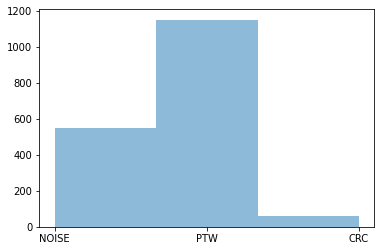

In [12]:
plt.hist(Y_calls, bins=3, alpha=0.5)

### View spectrograms that contain 'CRC'

In [52]:
v = np.where(Y_calls == 'CRC')[0]

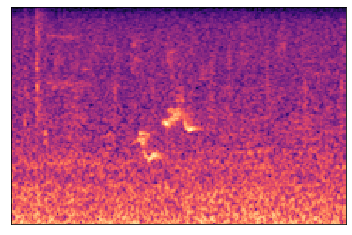

In [53]:
librosa.display.specshow(X_calls[v[2],:,:,0])

### View spectrograms that contain 'PTW'

In [54]:
v = np.where(Y_calls == 'PTW')[0]

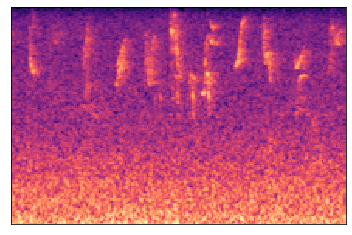

In [55]:
librosa.display.specshow(X_calls[v[21],:,:,0])

### Save to pickle

This will create X and Y variables which can then be read in for ML training.

Output will be saved in species_folder/Saved_Data

In [56]:
pre_pro.save_data_to_pickle(X_calls, Y_calls)